<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown 1y3u9WbrKggkiBglPfZk0ALmOpurpZq0B

In [ ]:
!unzip /content/66000-20221231T151019Z-001.zip

In [ ]:
!rm -rf /content/images

In [ ]:
!mkdir /content/images
!mkdir /content/images/train
!mkdir /content/images/train/generated
!mkdir /content/images/train/dataset
!mkdir /content/images/valid
!cp /content/66000/* /content/images/train/dataset
!cp /content/66000/66000.png /content/images/train/generated

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  DATA_DIR = '/content/images/train/'
  
  trans = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
  ])
  
  ds = ImageFolder(DATA_DIR, transform=trans)
  dl = DataLoader(ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dl

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

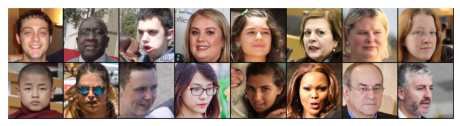

In [ ]:
image_size = 128

batch_size = 16

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_dl = get_dataloader(image_size, batch_size)

show_batch(train_dl)
#TODO: build dataloader and transfer it to device

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 32 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

Чтобы узнать, правильно ли мы адаптировали генератор взглянем на картинки

torch.Size([16, 3, 128, 128])


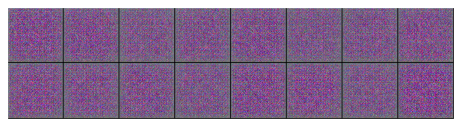

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)
plt.show()

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = '/content/images/train/generated'

In [ ]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

epochs = 93

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/93], loss_g: 9.4604, loss_d: 0.1002, real_score: 0.9631, fake_score: 0.0422
Saving generated-images-0001.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [2/93], loss_g: 19.4337, loss_d: 0.1099, real_score: 0.9758, fake_score: 0.0318
Saving generated-images-0002.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [3/93], loss_g: 19.3917, loss_d: 0.0503, real_score: 0.9844, fake_score: 0.0165
Saving generated-images-0003.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [4/93], loss_g: 15.0330, loss_d: 0.0464, real_score: 0.9860, fake_score: 0.0173
Saving generated-images-0004.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [5/93], loss_g: 11.1203, loss_d: 0.0350, real_score: 0.9850, fake_score: 0.0138
Saving generated-images-0005.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [6/93], loss_g: 7.7608, loss_d: 0.5426, real_score: 0.9451, fake_score: 0.0434
Saving generated-images-0006.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [7/93], loss_g: 5.4339, loss_d: 0.0736, real_score: 0.9740, fake_score: 0.0354
Saving generated-images-0007.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [8/93], loss_g: 8.1152, loss_d: 0.0317, real_score: 0.9874, fake_score: 0.0153
Saving generated-images-0008.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [9/93], loss_g: 9.8031, loss_d: 0.0237, real_score: 0.9903, fake_score: 0.0086
Saving generated-images-0009.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [10/93], loss_g: 8.5159, loss_d: 0.0124, real_score: 0.9943, fake_score: 0.0058
Saving generated-images-0010.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [11/93], loss_g: 9.0500, loss_d: 0.0069, real_score: 0.9965, fake_score: 0.0031
Saving generated-images-0011.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [12/93], loss_g: 7.7413, loss_d: 0.0044, real_score: 0.9982, fake_score: 0.0025
Saving generated-images-0012.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [13/93], loss_g: 15.8846, loss_d: 0.0171, real_score: 0.9929, fake_score: 0.0043
Saving generated-images-0013.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [14/93], loss_g: 7.8024, loss_d: 0.7694, real_score: 0.9153, fake_score: 0.0625
Saving generated-images-0014.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [15/93], loss_g: 9.1345, loss_d: 0.1810, real_score: 0.9452, fake_score: 0.0535
Saving generated-images-0015.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [16/93], loss_g: 7.4994, loss_d: 0.1028, real_score: 0.9702, fake_score: 0.0267
Saving generated-images-0016.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [17/93], loss_g: 7.1431, loss_d: 0.1688, real_score: 0.9565, fake_score: 0.0455
Saving generated-images-0017.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [18/93], loss_g: 6.5331, loss_d: 0.2422, real_score: 0.9455, fake_score: 0.0545
Saving generated-images-0018.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [19/93], loss_g: 6.3427, loss_d: 0.3107, real_score: 0.9161, fake_score: 0.0777
Saving generated-images-0019.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [20/93], loss_g: 5.6492, loss_d: 0.0729, real_score: 0.9717, fake_score: 0.0326
Saving generated-images-0020.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [21/93], loss_g: 5.8933, loss_d: 0.2818, real_score: 0.9330, fake_score: 0.0668
Saving generated-images-0021.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [22/93], loss_g: 6.9230, loss_d: 0.2193, real_score: 0.9504, fake_score: 0.0530
Saving generated-images-0022.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [23/93], loss_g: 7.2319, loss_d: 0.4319, real_score: 0.9153, fake_score: 0.0901
Saving generated-images-0023.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [24/93], loss_g: 6.3839, loss_d: 0.2642, real_score: 0.9249, fake_score: 0.0762
Saving generated-images-0024.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [25/93], loss_g: 6.6723, loss_d: 0.3137, real_score: 0.9177, fake_score: 0.0877
Saving generated-images-0025.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [26/93], loss_g: 6.4240, loss_d: 0.3813, real_score: 0.9091, fake_score: 0.1028
Saving generated-images-0026.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [27/93], loss_g: 5.1906, loss_d: 0.4263, real_score: 0.9029, fake_score: 0.1020
Saving generated-images-0027.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [28/93], loss_g: 6.2953, loss_d: 0.4081, real_score: 0.8970, fake_score: 0.1060
Saving generated-images-0028.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [29/93], loss_g: 6.4752, loss_d: 0.4178, real_score: 0.8930, fake_score: 0.1099
Saving generated-images-0029.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [30/93], loss_g: 6.3940, loss_d: 0.3817, real_score: 0.9030, fake_score: 0.1032
Saving generated-images-0030.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [31/93], loss_g: 6.4556, loss_d: 0.3053, real_score: 0.9000, fake_score: 0.0962
Saving generated-images-0031.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [32/93], loss_g: 6.9555, loss_d: 0.4538, real_score: 0.8771, fake_score: 0.1224
Saving generated-images-0032.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [33/93], loss_g: 6.8737, loss_d: 0.3619, real_score: 0.8978, fake_score: 0.1131
Saving generated-images-0033.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [34/93], loss_g: 7.2908, loss_d: 0.4755, real_score: 0.8750, fake_score: 0.1203
Saving generated-images-0034.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [35/93], loss_g: 5.9107, loss_d: 0.4447, real_score: 0.8807, fake_score: 0.1193
Saving generated-images-0035.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [36/93], loss_g: 6.4733, loss_d: 0.4474, real_score: 0.8789, fake_score: 0.1221
Saving generated-images-0036.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [37/93], loss_g: 6.7028, loss_d: 0.3996, real_score: 0.8867, fake_score: 0.1191
Saving generated-images-0037.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [38/93], loss_g: 6.7696, loss_d: 0.3981, real_score: 0.8811, fake_score: 0.1172
Saving generated-images-0038.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [39/93], loss_g: 6.9256, loss_d: 0.4861, real_score: 0.8660, fake_score: 0.1272
Saving generated-images-0039.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [40/93], loss_g: 6.4101, loss_d: 0.3928, real_score: 0.8883, fake_score: 0.1159
Saving generated-images-0040.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [41/93], loss_g: 6.5887, loss_d: 0.4467, real_score: 0.8759, fake_score: 0.1160
Saving generated-images-0041.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [42/93], loss_g: 6.2225, loss_d: 0.4028, real_score: 0.8874, fake_score: 0.1186
Saving generated-images-0042.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [43/93], loss_g: 6.9040, loss_d: 0.4822, real_score: 0.8696, fake_score: 0.1323
Saving generated-images-0043.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [44/93], loss_g: 6.3480, loss_d: 0.3867, real_score: 0.8828, fake_score: 0.1051
Saving generated-images-0044.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [45/93], loss_g: 6.4091, loss_d: 0.3489, real_score: 0.8945, fake_score: 0.1110
Saving generated-images-0045.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [46/93], loss_g: 6.5486, loss_d: 0.3429, real_score: 0.8960, fake_score: 0.1057
Saving generated-images-0046.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [47/93], loss_g: 6.7599, loss_d: 0.2943, real_score: 0.8972, fake_score: 0.0975
Saving generated-images-0047.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [48/93], loss_g: 6.2388, loss_d: 0.2869, real_score: 0.9035, fake_score: 0.0990
Saving generated-images-0048.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [49/93], loss_g: 7.2937, loss_d: 0.3310, real_score: 0.9069, fake_score: 0.0978
Saving generated-images-0049.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [50/93], loss_g: 7.8615, loss_d: 0.3759, real_score: 0.8885, fake_score: 0.1075
Saving generated-images-0050.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [51/93], loss_g: 6.3345, loss_d: 0.2890, real_score: 0.9082, fake_score: 0.0873
Saving generated-images-0051.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [52/93], loss_g: 6.8847, loss_d: 0.2753, real_score: 0.9200, fake_score: 0.0842
Saving generated-images-0052.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [53/93], loss_g: 6.5949, loss_d: 0.3274, real_score: 0.8966, fake_score: 0.1025
Saving generated-images-0053.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [54/93], loss_g: 6.6132, loss_d: 0.1833, real_score: 0.9307, fake_score: 0.0688
Saving generated-images-0054.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [55/93], loss_g: 8.1837, loss_d: 0.5367, real_score: 0.8850, fake_score: 0.1141
Saving generated-images-0055.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [56/93], loss_g: 6.2203, loss_d: 0.2640, real_score: 0.9136, fake_score: 0.0879
Saving generated-images-0056.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [57/93], loss_g: 6.7440, loss_d: 0.2356, real_score: 0.9146, fake_score: 0.0780
Saving generated-images-0057.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [58/93], loss_g: 7.4601, loss_d: 0.2400, real_score: 0.9198, fake_score: 0.0800
Saving generated-images-0058.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [59/93], loss_g: 7.2804, loss_d: 0.2084, real_score: 0.9316, fake_score: 0.0685
Saving generated-images-0059.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [60/93], loss_g: 7.7058, loss_d: 0.3710, real_score: 0.9012, fake_score: 0.0921
Saving generated-images-0060.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [61/93], loss_g: 6.5081, loss_d: 0.1609, real_score: 0.9399, fake_score: 0.0646
Saving generated-images-0061.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [62/93], loss_g: 8.7302, loss_d: 0.3011, real_score: 0.9182, fake_score: 0.0831
Saving generated-images-0062.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [63/93], loss_g: 7.5983, loss_d: 0.1565, real_score: 0.9408, fake_score: 0.0574
Saving generated-images-0063.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [64/93], loss_g: 7.3182, loss_d: 0.1619, real_score: 0.9411, fake_score: 0.0565
Saving generated-images-0064.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [65/93], loss_g: 7.5125, loss_d: 0.1839, real_score: 0.9406, fake_score: 0.0614
Saving generated-images-0065.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [66/93], loss_g: 8.7226, loss_d: 0.2904, real_score: 0.9252, fake_score: 0.0731
Saving generated-images-0066.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [67/93], loss_g: 8.0618, loss_d: 0.2704, real_score: 0.9320, fake_score: 0.0659
Saving generated-images-0067.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [68/93], loss_g: 7.4535, loss_d: 0.2129, real_score: 0.9262, fake_score: 0.0691
Saving generated-images-0068.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [69/93], loss_g: 7.6398, loss_d: 0.1431, real_score: 0.9479, fake_score: 0.0544
Saving generated-images-0069.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [70/93], loss_g: 9.1795, loss_d: 0.3862, real_score: 0.9109, fake_score: 0.0910
Saving generated-images-0070.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [71/93], loss_g: 6.6617, loss_d: 0.1649, real_score: 0.9354, fake_score: 0.0577
Saving generated-images-0071.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [72/93], loss_g: 8.1372, loss_d: 0.2666, real_score: 0.9271, fake_score: 0.0748
Saving generated-images-0072.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [73/93], loss_g: 7.6942, loss_d: 0.1847, real_score: 0.9358, fake_score: 0.0662
Saving generated-images-0073.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [74/93], loss_g: 8.1274, loss_d: 0.1511, real_score: 0.9457, fake_score: 0.0502
Saving generated-images-0074.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [75/93], loss_g: 8.2690, loss_d: 0.2050, real_score: 0.9393, fake_score: 0.0596
Saving generated-images-0075.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [76/93], loss_g: 8.0868, loss_d: 0.1791, real_score: 0.9418, fake_score: 0.0590
Saving generated-images-0076.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [77/93], loss_g: 8.4639, loss_d: 0.1723, real_score: 0.9393, fake_score: 0.0559
Saving generated-images-0077.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [78/93], loss_g: 7.9016, loss_d: 0.1194, real_score: 0.9556, fake_score: 0.0456
Saving generated-images-0078.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [79/93], loss_g: 9.2242, loss_d: 0.2324, real_score: 0.9378, fake_score: 0.0649
Saving generated-images-0079.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [80/93], loss_g: 9.2510, loss_d: 0.2205, real_score: 0.9364, fake_score: 0.0597
Saving generated-images-0080.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [81/93], loss_g: 6.9274, loss_d: 0.1203, real_score: 0.9537, fake_score: 0.0450
Saving generated-images-0081.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [82/93], loss_g: 7.9068, loss_d: 0.1020, real_score: 0.9624, fake_score: 0.0382
Saving generated-images-0082.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [83/93], loss_g: 9.3529, loss_d: 0.1830, real_score: 0.9423, fake_score: 0.0529
Saving generated-images-0083.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [84/93], loss_g: 7.2890, loss_d: 0.0811, real_score: 0.9678, fake_score: 0.0355
Saving generated-images-0084.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [85/93], loss_g: 8.7661, loss_d: 0.1062, real_score: 0.9613, fake_score: 0.0368
Saving generated-images-0085.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [86/93], loss_g: 10.9107, loss_d: 0.2494, real_score: 0.9380, fake_score: 0.0603
Saving generated-images-0086.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [87/93], loss_g: 8.4582, loss_d: 0.1331, real_score: 0.9591, fake_score: 0.0474
Saving generated-images-0087.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [88/93], loss_g: 8.2374, loss_d: 0.1228, real_score: 0.9575, fake_score: 0.0385
Saving generated-images-0088.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [89/93], loss_g: 9.2889, loss_d: 0.1790, real_score: 0.9453, fake_score: 0.0540
Saving generated-images-0089.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [90/93], loss_g: 8.8929, loss_d: 0.1359, real_score: 0.9567, fake_score: 0.0431
Saving generated-images-0090.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [91/93], loss_g: 9.3057, loss_d: 0.1905, real_score: 0.9498, fake_score: 0.0521
Saving generated-images-0091.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [92/93], loss_g: 9.4928, loss_d: 0.1979, real_score: 0.9407, fake_score: 0.0579
Saving generated-images-0092.png


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [93/93], loss_g: 8.7006, loss_d: 0.2498, real_score: 0.9345, fake_score: 0.0640
Saving generated-images-0093.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

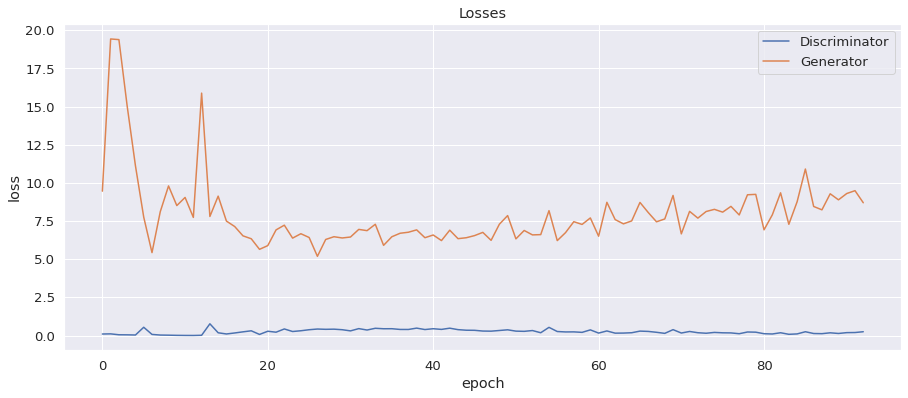

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

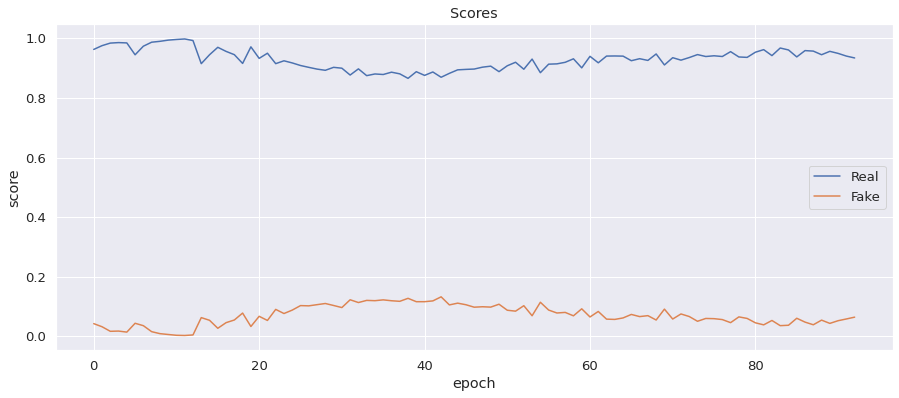

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

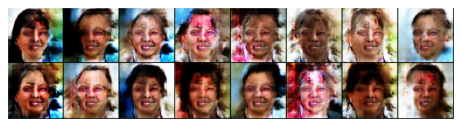

In [ ]:
generated_img = cv2.imread(f'/content/images/train/generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)
plt.show()

torch.Size([16, 3, 128, 128])


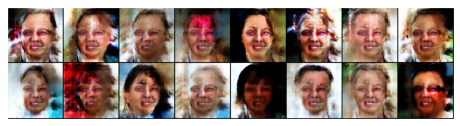

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1).to('cuda')
fake_images = model['generator'](xb).to('cpu')
print(fake_images.shape)
show_images(fake_images)
plt.show()

Как вам качество получившихся изображений?

— Выгляит страшненько, но потенциал есть. В идеале, надо бы, наверное, увеличить размерность латентного вектора и прогнать гораздо больше эпох. Зато видно на чём сеть халтурит (глаза и улыбка, как минимум).

In [ ]:
import pickle

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/model.pickle /content/drive/MyDrive/ganhw/

In [ ]:
!cp /content/drive/MyDrive/ganhw/model.pickle /content/

In [ ]:
import pickle

with open('model.pickle', 'rb') as f:
    model_l = pickle.load(f)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

torch.Size([1, 3, 128, 128])


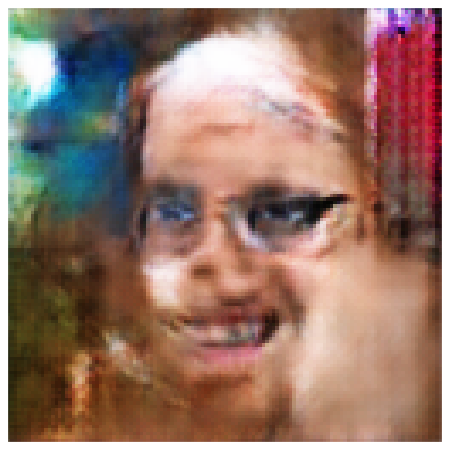

In [ ]:
xb = torch.randn(1, latent_size, 1, 1).to('cuda')
fake_images = model_l['generator'](xb).to('cpu')
print(fake_images.shape)
show_images(fake_images)
plt.show()

In [ ]:
def save_sample_new(index):
    xb = torch.randn(1, latent_size, 1, 1).to('cuda')
    fake_images = model_l['generator'](xb).to('cpu')
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

In [ ]:
save_sample_new(-1)

Saving generated-images--001.png


In [ ]:
for i in range(1000):
    save_sample_new(i)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=1)

In [ ]:
DATA_DIR = '/content/images/train/'

trans = tt.Compose([
  tt.Resize(image_size),
  tt.CenterCrop(image_size),
  tt.ToTensor(),
  tt.Normalize(*stats)
])
  
ds = ImageFolder(DATA_DIR, transform=trans)

In [ ]:
X = []
Y = []

for x, y in ds:
  X.append(x.numpy().flatten())
  Y.append(y)

X = np.array(X)
Y = np.array(Y)

In [ ]:
print(X[:-1].shape, Y[:-1].shape)

(2000, 49152) (2000,)


In [ ]:
hren = list(zip(X, Y))

np.random.shuffle(hren)

X = []
Y = []

for x, y in hren:
  X.append(x)
  Y.append(y)

X = np.array(X)
Y = np.array(Y)

In [ ]:
Y[1001]

0

In [ ]:
classifier.fit(X[:-1], Y[:-1])

KNeighborsClassifier(n_neighbors=1)

In [ ]:
classifier.score(np.array([X[-1]]), np.array([Y[-1]]))

1.0

In [ ]:
xb = torch.randn(100, latent_size, 1, 1).to('cuda')
fake_images = model_l['generator'](xb).to('cpu')

In [ ]:
classifier.score(np.array([fake_image.detach().numpy().flatten() for fake_image in fake_images]), np.array([1]*100))

0.97

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

scores = []

for train, test in loo.split(X, Y):
  classifier.fit(X[train], Y[train])
  scores.append(classifier.score(X[test], Y[test]))

In [ ]:
np.mean(scores)

0.9980009995002499

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Было бы славно получить accuracy в районе 0.5, однако у нас получилось что-то странное и неприятное. Ну ладно, всё равно такое себе качество изображений. Наверное, этого и следовало ожидать. 

Почему 0.5? Это означало бы, что сгенерированные картинки очень трудно отличить от настоящих и KNN работает не лучше идеальной монетки.


### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

embeded = TSNE().fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
Y.shape

(2001,)

In [ ]:
embeded.shape

(2001, 2)

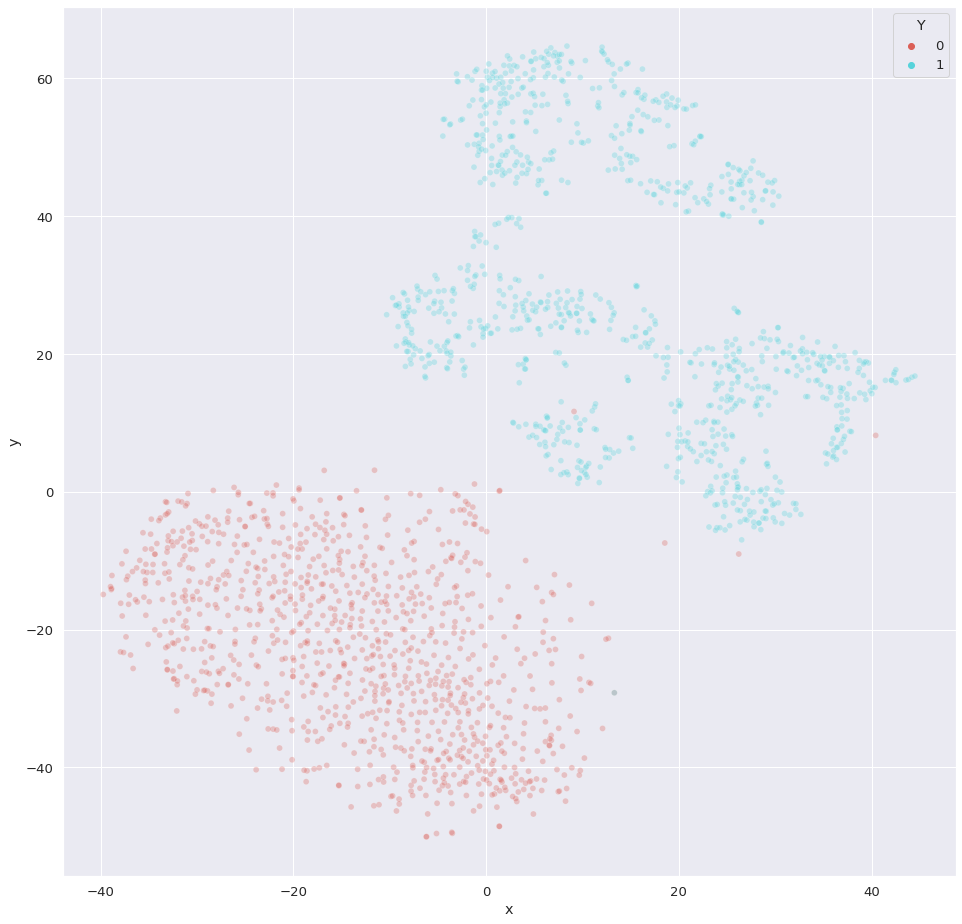

In [ ]:
import seaborn as sns


data = {
    'x': embeded[:,0],
    'y': embeded[:,1],
    'Y': Y
}


plt.figure(figsize=(16,16))
ax1 = plt.subplot(1, 1, 1)
sns.scatterplot(
    x="x", y="y",
    hue="Y",
    palette=sns.color_palette("hls", 2),
    data=data,
    legend="full",
    alpha=0.3,
    ax=ax1
)

Прокомментируйте получившийся результат:

Ну, получилось так себе. По хорошему, в идеале, если б прям всё было прекрасно, было бы распределение на две почти неотличимые группы, а тут... Ну, будь что будет